In [1]:
%matplotlib notebook
# %matplotlib inline
import numpy as np
from scipy.linalg import block_diag
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Polynomial Trajectory Optimization for Multirotors

Trajectory optimization is an often-used strategy for robotic motion planning. In general, an *optimal control problem* (OCP) is formulated which minimizes some objective while satisfying dynamic and possibly other constraints. The general OCP can then be solved using a variety of techniques, either analytical (e.g., dynamic programming, calculus of variations, Pontryagin's Maximum Principle) or numerical (e.g., direct transcription, collocation, shooting methods) [[1]](#Bibliography). An important difference between the analytical and numerical solutions is that analytical solutions provide a control policy that can be used anywhere in the state space, while numerical solutions represent a single trajectory through the state space given some initial condition [[2, Chap 10]](#Bibliography).

Prior to the popularity of trajectory optimization for motion planning, many ad-hoc ... waypoint .. bounded jerk, linear segment polynomial blends (LSPB) ...

In this notebook, we are interested specifically in trajectory optimization for multirotors, which are well-known to be [differentially flat](http://planning.cs.uiuc.edu/node850.html) [[3]](#Bibliography). This property of multirotor dynamics allows motion planning to be performed with polynomials in each of the multirotor's *flat* states: $x(t)$, $y(t)$, $z(t)$, $\psi(t)$---3D position and yaw. Motion planning via polynomial trajectory optimization significantly simplifies the OCP and its solution. In fact, the choice of polynomial basis functions leads to a quadratic program (QP), for which there are [many](https://pypi.org/project/qpsolvers/) fast, off-the-shelf solvers that can be used.

splines .. waypoints ...

other popular bases: bezier, b-spline, [clamped b-spline](https://hal.archives-ouvertes.fr/hal-02275008/file/cep2019_HAL.pdf)

## Interlude - Quadratic Programming in Python

Quadratic programs (QPs) are of the following form

$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{x}\,\in\,\mathbb{R}^n}{\text{minimize}}
& & \mathbf{x}^\top \mathbf{Q}\,\mathbf{x} + \mathbf{f}^\top\,\mathbf{x}  \\
& \text{subject to}
& & \mathbf{A}\mathbf{x} = \mathbf{b} \\
&&& \mathbf{G}\mathbf{x} \le \mathbf{h}
\end{aligned}
\end{equation*}
$$

where $\mathbf{Q}\in\mathcal{S}^n_+$ is positive semi-definite (n.b., some solvers require positive definiteness, i.e., $\mathbf{Q}\in\mathcal{S}^n_{++}$). The optimization, or decision, variable is $\mathbf{x}\in\mathbb{R}^n$ and $\mathbf{Q}, \mathbf{f}, \mathbf{A}, \mathbf{b}, \mathbf{G}, \mathbf{h}$ are problem-dependent data. Notice that a quadratic program has a quadratic objective, which is convex due to the p.s.d constraint, and linear constraints.

These problems can be efficiently solved using an off-the-shelf solver. Below is a Python example.

In [2]:
from qpsolvers import solve_qp, available_solvers

print(available_solvers)

# from https://pypi.org/project/qpsolvers/
M = np.array([[1., 2., 0.], [-8., 3., 2.], [0., 1., 1.]])
P = M.T @ M  # quick way to build a symmetric matrix
q = (np.array([3., 2., 3.]) @ M).reshape((3,))
G = np.array([[1., 2., 1.], [2., 0., 1.], [-1., 2., -1.]])
h = np.array([3., 2., -2.]).reshape((3,))
A = np.array([1., 1., 1.])
b = np.array([1.])

print("QP solution:", solve_qp(P, q, G, h, A, b))

['cvxopt', 'osqp', 'quadprog']
QP solution: [ 0.30769231 -0.69230769  1.38461538]


## Problem Overview

There are two primary methods for solving the polynomial trajectory optimization problems, due to Mellinger [3] and Richter [4].

[3] - decision variables are poly coefficients ==> can't have too many waypoints

[4] - decision variables are endpoints, closed-form solution

### Time Allocation

First, we will assume pre-specified time allocation for simplicity. This can be done naively by considering the amount of time it takes to go between two waypoints given the distance and the maximum translational velocity allowed.

See [4] and [5] for more on a nonlinear optimization formulation that considers time allocation.

## Problem Formulation

A complete trajectory over $M+1$ waypoints $\{p_i\}_{i=0}^M$ can be formulated as a piecewise function of time $\sigma:\mathbb{R}\to\mathbb{R}$, defined as

$$
\begin{gather*}
\sigma(t) = 
\left\{
\begin{array}{ll}
\sigma_1(t) & t_0 \le t < t_1 \\
\sigma_2(t) & t_1 \le t < t_2 \\
\vdots & \vdots \\
\sigma_M(t) & t_{M-1} \le t < t_M = T \\
\end{array}
\right.
\end{gather*}.
$$

For the basis functions $\sigma_i(t)$, we choose polynomials as motivated by the discussion above. An $N$-th order polynomial may be written as
$$
\sigma_i(t) = c_{iN} t^N + c_{iN-1}t^{N-1} + \dots + c_{i0} = \mathbf{c}_i^\top \mathbf{t},
$$
where $\mathbf{c}_i = \begin{bmatrix}c_{i0} & c_{i1} & c_{i2} & \dots & c_{iN} \end{bmatrix}^\top$ and $\mathbf{t} = \begin{bmatrix}1 & t & t^2 & \dots & t^{N} \end{bmatrix}^\top$.

We seek to minimize the squared snap while ensuring continuity, which amounts to the following OCP
$$
\begin{equation*}
\begin{aligned}
& \underset{\sigma(t)\,\in\,\mathbb{R}}{\text{minimize}}
& & J(\sigma) = \int_0^T  \left(\frac{d^4\sigma(\tau)}{d\tau^4}\right)^2 d\tau  \\
& \text{subject to}
& & \text{starting and ending at rest} \\
&&& \text{attaining each waypoint} \\
&&& \text{continuity of segments} \\
\end{aligned}
\end{equation*}
$$

Following [3], [4] we reformulate this OCP as a quadratic program (QP). First, we focus on the functional $J(\sigma)$. As the desired trajectory $\sigma(t)$ is a piecewise function of $M$ segments (with endpoints corresponding to $M+1$ waypoints), we can write
$$
\begin{align*}
J(\sigma) &= \sum_{i=0}^M \int_{t_i}^{t_{i+1}} \left(\frac{d^4\sigma_i(\tau)}{d\tau^4}\right)^2 d\tau \\
&= \sum_{i=0}^M J_i,
\end{align*}
$$
where $J_i$ is the cost per polynomial segment. These segment costs can be rewritten and stacked into a quadratic form.

[Recall](https://math.stackexchange.com/a/1937696/481663) that the square of an N-th order polynomial can be written using a discrete convolution sum of its coefficients
$$
\sigma^2(t) = \sum_{k=0}^{2N}\left( \sum_{j=0}^k c_{k-j} c_{j} \right)t^k,
$$
and the $r$-th derivative of an $N$-th order polynomial can be written
$$
\frac{d^r}{dt^r}\sigma(t) = \sum_{n=r}^N\left( \prod_{m=0}^{r-1}(n-m) \right) c_n t^{n-r}.
$$
So,
$$
\begin{align*}
\left(\frac{d^r}{dt^r}\sigma(t)\right)^2
&= \left( \sum_{n=r}^N \alpha(n) t^{n-r} \right)^2, \quad\text{where}\;\alpha(n;r)\stackrel{\Delta}{=}\prod_{m=0}^{r-1}(n-m)c_n \\
&= \sum_{k=2r}^{2N} \left( \sum_{j=0}^k \alpha(k-j)\alpha(j) \right) t^{k-2r} \\
&= \sum_{k=2r}^{2N} \left( \sum_{j=0}^k \left\{ \prod_{m=0}^{r-1}(k-j-m)(j-m) \right\} c_{k-j} c_j \right) t^{k-2r}. \\
\end{align*}
$$

Using these expressions, we can write
$$
\begin{align*}
J_i &= \int_{t_i}^{t_{i+1}} \left(\frac{d^r\sigma_i(\tau)}{d\tau^r}\right)^2 d\tau \\
&= \int_{t_i}^{t_{i+1}} \left( \sum_{n=r}^N\left( \prod_{m=0}^{r-1}(n-m) \right) c_{in} \tau^{n-r} \right)^2 d\tau \\
&= \int_{t_i}^{t_{i+1}} \sum_{k=2r}^{2N} \sum_{j=0}^k \left( \prod_{m=0}^{r-1}(k-j-m)(j-m) \right) c_{i,k-j} c_{ij} \tau^{k-2r} d\tau \\
&= \sum_{k=2r}^{2N} \sum_{j=0}^k \left( \prod_{m=0}^{r-1}(k-j-m)(j-m) \right) c_{i,k-j} c_{ij} \int_{t_i}^{t_{i+1}} \tau^{k-2r} d\tau \\
&= \sum_{k=2r}^{2N} \sum_{j=0}^k \left( \prod_{m=0}^{r-1}(k-j-m)(j-m) \right) c_{i,k-j} c_{ij} \frac{t_{si}^{k-2r+1}}{k-2r+1} \\
\end{align*}
$$
where $t_{si}=t_{i+1}-t_i$ is the segment time of the $i$-th segment between waypoints $i$ and $i+1$.
<font color='red'>(Is $t_i$ assumed to be 0? Otherwise, the integral should give $\frac{t_{i+1}^{k-2r+1} - t_{i}^{k-2r+1}}{k-2r+1}$)</font>
Since terms of the $J_i$ are quadratic w.r.t polynomial coefficients $c_{ij}$, we can find the $Q$ of the associated quadratic form $\mathbf{c}_i^\top Q\,\mathbf{c}_i$ by taking the Hessian (i.e., second derivative) of this expression, making frequent use of the sifting property
$$
\begin{align*}
\frac{\partial J_i}{\partial c_{io}} &= \sum_{k=2r}^{2N} \sum_{j=0}^k \left( \prod_{m=0}^{r-1}(k-j-m)(j-m) \right) \frac{\partial c_{i,k-j} c_{ij}}{\partial c_{io}} \frac{t_{si}^{k-2r+1}}{k-2r+1} \\
&= \sum_{k=2r}^{2N} \sum_{j=0}^k \left\{\dots\right\} \frac{\partial c_{i,k-j} c_{ij}}{\partial c_{io}} \\
&= \sum_{k=2r}^{2N} \sum_{j=0}^k \left\{\dots\right\} \left( \frac{\partial c_{i,k-j}}{\partial c_{io}}c_{ij} + \frac{\partial c_{ij}}{\partial c_{io}}c_{i,k-j} \right) \\
&= \sum_{k=2r}^{2N} \sum_{j=0}^k \left\{\dots\right\} \left( \delta(k-j-o)c_{ij} + \delta(j-o)c_{i,k-j} \right) &(\text{Reminder: }\delta(x-a)=1\,\text{for }x=a,\text{ and }0\text{ o.w.}) \\
&&(\text{Not sure how the next step is obtained though..})\\
&= 2\sum_{k=2r}^{2N} \left( \prod_{m=0}^{r-1}(k-o-m)(o-m) \right) c_{i,k-o} \frac{t_{si}^{k-2r+1}}{k-2r+1} \\
& \\
\frac{\partial^2 J_i}{\partial c_{io}\partial c_{ip}} &= 2\sum_{k=2r}^{2N} \left\{\dots\right\} \frac{\partial c_{i,k-o}}{\partial c_{ip}} \\
&= 2\sum_{k=2r}^{2N} \left\{\dots\right\} \delta(k-o-p) \\
&= 2 \left( \prod_{m=0}^{r-1}(p-m)(o-m) \right) \frac{t_{si}^{o+p-2r+1}}{o+p-2r+1} \\
\end{align*}
$$

Observing that coefficients with order less than the derivative order are $0$, we have for the $i$-th segment
$$
\begin{gather*}
[Q_i]_{op} =
\left\{
\begin{array}{ll}
    2 \left( \prod_{m=0}^{r-1}(p-m)(o-m) \right) \frac{1}{o+p-2r+1}t_{si}^{o+p-2r+1} & o\ge r \;\text{and}\; p\ge r \\
    0 & \text{else}
\end{array}
\right..
\end{gather*}
$$

Each segment's cost matrix can then be stacked in a block diagonal to form the total $J(\sigma)$ cost
$$
J(\sigma) = \mathbf{c}^\top \mathbf{Q}\,\mathbf{c} = 
\begin{bmatrix}
\mathbf{c}_1 \\ \vdots \\ \mathbf{c}_i \\ \vdots \\ \mathbf{c}_M
\end{bmatrix}^\top
\begin{bmatrix}
Q_1 \\
& \ddots \\
&& Q_i \\
&&& \ddots \\
&&&& Q_M
\end{bmatrix}
\begin{bmatrix}
\mathbf{c}_1 \\ \vdots \\ \mathbf{c}_i \\ \vdots \\ \mathbf{c}_M
\end{bmatrix}
$$
and the previously stated OCP becomes the following QP
$$
\begin{equation*}
\begin{aligned}
& \underset{\mathbf{c}\,\in\,\mathbb{R}^{M(N+1)}}{\text{minimize}}
& & \mathbf{c}^\top \mathbf{Q}\,\mathbf{c}  \\
& \text{subject to}
& & \mathbf{A}\mathbf{c} = \mathbf{b}
\end{aligned}
\end{equation*}
$$
where the construction of the linear equality constraints are outlined below.


## Constraints

In the original OCP formulation, we listed three constraints in English: (1) starting and ending at rest, (2) attaining each waypoint, (3) continuity of segments. Each of these constraints can be formulated as linear equalities of the form $\mathbf{A}\mathbf{c}=\mathbf{b}$ in the decision variable $\mathbf{c}$, i.e., the polynomial coefficients. Note how each row of $\mathbf{A}$ selects the time instant that we would like to enforce a constraint along the polynomial, and $\mathbf{b}$ at that row contains the position, velocity, etc. that we would like the polynomial evaluated at that time instant to achieve.

Recall that a polynomial $\sigma_i(t) = \mathbf{c}_i^\top\mathbf{t}$, where $\mathbf{t}$ is a vector of $N$ monomials in $t$. We will use the notation $\mathbf{t}|_r(t)$ to denote this vector of time monomials associated to the $r$-th derivative of $\sigma_i(t)$, evaluated at time $t$. Also recall that $\{t_{si}\}_{i=1}^M$ is the set of segment durations, where each segment corresponds to the polynomial $\sigma_i(t)$ between two of the $M+1$ waypoints, $\{p_i\}_{i=0}^M$.


### Starting and Ending at Rest

The first and the last polynomial segments are constrained as

$$
\begin{bmatrix}
&& \mathbf{t}|_0(0)^\top && \\
&& \mathbf{t}|_1(0)^\top && \\
&& \vdots && \\
&& \mathbf{t}|_r(0)^\top && \\
\end{bmatrix}
\mathbf{c}_1
=
\begin{bmatrix}
p_0 \\ 0 \\ \vdots \\ 0
\end{bmatrix}
\qquad\text{and}\qquad
\begin{bmatrix}
&& \mathbf{t}|_0(t_{sM})^\top && \\
&& \mathbf{t}|_1(t_{sM})^\top && \\
&& \vdots && \\
&& \mathbf{t}|_r(t_{sM})^\top && \\
\end{bmatrix}
\mathbf{c}_M
=
\begin{bmatrix}
p_M \\ 0 \\ \vdots \\ 0
\end{bmatrix},
$$

which can be stacked to become

$$
\begin{bmatrix}
& \mathbf{t}|_0(0)^\top && \mathbf{0} & \dots & \mathbf{0} & \\
& \mathbf{t}|_1(0)^\top && \mathbf{0} & \dots & \mathbf{0} & \\
& \vdots && \vdots & \dots & \vdots & \\
& \mathbf{t}|_r(0)^\top && \mathbf{0} & \dots & \mathbf{0} & \\
& \mathbf{0} && \mathbf{0} & \dots & \mathbf{t}|_0(t_{sM})^\top & \\
& \mathbf{0} && \mathbf{0} & \dots & \mathbf{t}|_1(t_{sM})^\top & \\
& \mathbf{0} && \mathbf{0} & \dots & \vdots & \\
& \mathbf{0} && \mathbf{0} & \dots & \mathbf{t}|_r(t_{sM})^\top & \\
\end{bmatrix}
\mathbf{c}
=
\begin{bmatrix}
p_0 \\ 0 \\ \vdots \\ 0 \\
p_M \\ 0 \\ \vdots \\ 0
\end{bmatrix}.
$$


### Attaining Each Waypoint

Notice how the waypoint at the *end* of each segment is constrained, except the last segment. This prevents extra position constraints on the first and last waypoint, which were already constrained due to starting and ending at rest. Obviously, the last row of zeros in $\mathbf{A}$ and $\mathbf{b}$ can be excluded and are only shown to accentuate that we do not add extra constraints on the final waypoint.

$$
\begin{bmatrix}
& \mathbf{t}|_0(t_{s1})^\top & \mathbf{0} & \dots & \mathbf{0} & \mathbf{0} & \\
& \mathbf{0} & \mathbf{t}|_0(t_{s2})^\top & \dots & \mathbf{0} & \mathbf{0} & \\
& \mathbf{0} & \mathbf{0} & \ddots                & \mathbf{0} & \mathbf{0} & \\
& \mathbf{0} & \mathbf{0} & \dots                 & \mathbf{t}|_0(t_{sM-1})^\top & \mathbf{0} & \\
& \mathbf{0} & \mathbf{0} & \mathbf{0}            & \mathbf{0} & \mathbf{0} &
\end{bmatrix}
\mathbf{c}
=
\begin{bmatrix}
p_1 \\ p_2 \\ \vdots \\ p_{M-1} \\ 0
\end{bmatrix}
$$

### Continuity of Segments

Here, we constrain the end position (and derivatives) of each segment $\sigma_i(t)$ to match the beginning position (and derivatives) of the following segment $\sigma_{i+1}(t)$ to ensure smoothness of the overall trajectory $\sigma(t)$.

$$
\begin{bmatrix}
& \mathbf{t}|_0(t_{s1})^\top & -\mathbf{t}|_0(0)^\top & \mathbf{0} & \dots & \mathbf{0} & \mathbf{0} & \\
& \vdots & \vdots & \vdots & \dots & \vdots & \vdots & \\
& \mathbf{t}|_r(t_{s1})^\top & -\mathbf{t}|_r(0)^\top & \mathbf{0} & \mathbf{0} & \mathbf{0} & \mathbf{0} & \\
& \mathbf{0} & \mathbf{t}|_0(t_{s2})^\top & -\mathbf{t}|_0(0)^\top & \dots & \mathbf{0} & \mathbf{0} & \\
& \vdots & \vdots & \vdots & \dots & \vdots & \vdots & \\
& \mathbf{0} & \mathbf{t}|_r(t_{s2})^\top & -\mathbf{t}|_r(0)^\top & \dots & \mathbf{0} & \mathbf{0} & \\
& & & & \ddots & & & & \\
& \mathbf{0} & \mathbf{0} & \mathbf{0} & & \mathbf{t}|_0(t_{sM-1})^\top & -\mathbf{t}|_0(0)^\top \\
& \mathbf{0} & \mathbf{0} & \mathbf{0} & & \vdots & \vdots \\
& \mathbf{0} & \mathbf{0} & \mathbf{0} & & \mathbf{t}|_r(t_{sM-1})^\top & -\mathbf{t}|_r(0)^\top
\end{bmatrix}
\mathbf{c}
=
\mathbf{0}
$$

In [3]:
import numpy as np
from qpsolvers import solve_qp

class Trajectory:
    def __init__(self, N, M, r, d, ts, wps):
        self.N = N # polynomial order
        self.r = r # derivative to minimize
        self.d = d # spatial dimension of trajectory
        self.ncoeffs = self.N + 1 # number of poly coefficients
        self.M = M # number of segments (num waypoints - 1)
        self.ts = ts # segment durations
        self.wpt = np.cumsum(self.ts) # time at each wp
        self.wps = wps # original waypoint path specification
        
        self.polys = np.zeros((self.d, self.M*self.ncoeffs))
        
    def _get_seg_idx_range(self, i):
        """Get Segment Index Range
        Computes the appropriate index slice corresponding to the N+1
        coefficients of the ith polynomial segment.
        """
        return np.s_[ i*self.ncoeffs : (i+1)*self.ncoeffs ]
    
    def _polyval(self, c, t, r):
        """Evaulate the rth derivative of a polynomial with coeffs c at time t
        """
        def prod(r, n):
            x = 1
            for m in range(r):
                x *= (n - m)
            return x
        
        x = 0
        for n in range(len(c)):
            if n >= r:
                x += prod(r, n) * c[n] * t**(n-r)
        return x
        
    def set_poly(self, coeffs, dim=0):
        self.polys[dim,:] = coeffs
        
    def eval(self, t):
        """Evaluate the trajectory at a given time
        :ret: rxd np.array
        """
        x = np.zeros((self.r,self.d))
        
        for i in range(self.M):
            t0 = self.wpt[i-1] if i>0 else 0
            t1 = self.wpt[i]
            if t0 <= t < t1:
                tau = t - t0
                for d in range(self.d):
                    ci = self.polys[d, self._get_seg_idx_range(i)]
                    for r in range(self.r):
                        x[r,d] = self._polyval(ci, tau, r)
        return x
    
    def plot(self, Ts=0.01, linewidth=2):
        N = round(float(self.wpt[-1] / Ts)) # num samples
        X = np.zeros((self.r,self.d, N))
        
        for i in range(N):
            X[:,:,i] = self.eval(i*Ts)
            
        tvec = [i*Ts for i in range(N)]
        
#         fig = plt.figure(figsize=(10,4), dpi=100)
        fig = plt.figure(dpi=100)
        fig.subplots_adjust(hspace=0.3)
        if self.d == 3:
            ax = fig.add_subplot(111, projection='3d')
            ax.plot3D(X[0,0,:],X[0,1,:],X[0,2,:], linewidth=linewidth)
            
            # straight line path + waypoints
            ax.plot3D(self.wps[:,0],self.wps[:,1],self.wps[:,2],c='k')
            ax.scatter3D(self.wps[:,0],self.wps[:,1],self.wps[:,2],s=30,c='k')
            
            ax.grid()
            ax.set_title('Trajectory')
            ax.set_xlabel('X [m]')
            ax.set_ylabel('Y [m]')
            ax.set_zlabel('Z [m]')
        else:
            print("Only 3D trajectory plotting implemented")
        
        return fig, ax
            
    def plot_derivative(self, r, Ts=0.01):
        assert r > 0
        assert self.d == 3
        dim_names = ['x [m]', 'y [m]', 'z [m]']
        N = round(float(self.wpt[-1] / Ts)) # num samples
        X = np.zeros((self.r, self.d, N))
        
        for i in range(N):
            X[:,:,i] = self.eval(i*Ts)
            
        tvec = [i*Ts for i in range(N)]
        
        fig, axes = plt.subplots(1, self.d, figsize=(self.d*2, 2), dpi=100)
        fig.subplots_adjust(wspace=0.5)
        for i, dim in enumerate(dim_names):
            ax = axes[i]
            ax.plot(tvec, X[r,i,:])
            ax.grid()
            ax.set_title('{}-th Derivative'.format(r))
            ax.set_xlabel('t [s]')
            ax.set_ylabel(dim)
        return fig, axes


class MinimumSnapQP:
    """
    Formulates the minimum-snap polynomial trajectory
    optimization problem as a QP of the form
    
        min  c'Qc
        s.t  Ac = b
    """
    def __init__(self, N=7, r=4, d=3):
        self.N = N # polynomial order
        self.r = r # derivative to minimize
        self.d = d # spatial dimension of trajectory
        self.ncoeffs = self.N + 1 # number of poly coefficients
        self.M = 0 # number of segments (num waypoints - 1)
        self.L = 0 # length of decision variable c, i.e., M(N+1)
    
    def _initial_time_allocation(self, wps, T):
        ts = []
        t = T / self.M
        for i in range(self.M):
            ts.append(t)
        
        return ts
    
    def _build_Qi(self, tsi=1):
        """Build quadratic cost matrix of i-th segment
        Note that each Qi is only a function of segment duration.
        """
        Qi = np.zeros((self.ncoeffs, self.ncoeffs))
        
        def prod(r, o, p):
            x = 1
            for m in range(r):
                x *= (o-m) * (p-m)
            return x
        
        for o in range(self.ncoeffs):
            for p in range(self.ncoeffs):
                if o >= self.r and p >= self.r: # equivalently, e > 0
                    e = o + p - 2*self.r + 1
                    Qi[o,p] = 2 * prod(self.r, o, p) * tsi**e / e
        return Qi
    
    def _build_Q(self, ts):
        """Build total quadratic
        This is Q = blkdiag(Q1, ..., Q_M).
        """
        Q = np.zeros((self.M*self.ncoeffs, self.M*self.ncoeffs))
        
        for i in range(self.M):
            idx = self._get_seg_idx_range(i)
            Q[idx, idx] = self._build_Qi(ts[i])
        return Q
    
    def _get_seg_idx_range(self, i):
        """Get Segment Index Range
        Computes the appropriate index slice corresponding to the N+1
        coefficients of the ith polynomial segment.
        """
        return np.s_[ i*self.ncoeffs : (i+1)*self.ncoeffs ]
    
    def _get_tvec_at(self, t, r=0):
        """Creates time vector associated with polynomial.
        σ(t) = c_0  +  c_1 t  + ... +  c_N t^N = <c,tvec>,
        with tvec|r=0 = [1 t ... t^N], tvec|r=1 = [0 1 ... t^(N-1)], ...
        :return: tvec associated with rth derivative of σ(t), eval at time t.
        """
        def prod(r, n):
            x = 1
            for m in range(r):
                x *= (n - m)
            return x
        
        tvec = np.zeros((self.ncoeffs,))
        for n in range(self.ncoeffs):
            if n >= r:
                tvec[n] = prod(r, n) * t**(n-r)
        return tvec
    
    def _constraint_endpoints(self, wps, ts):
        """Endpoint Constraints
        Enforce that the starting and ending positions are met at rest.
        """
        k = 2 # number of waypoints being constrained (start and end points)
        A = np.zeros((k*self.r, self.L))
        b = np.zeros((k*self.r,))
        
        # constraints on starting position (at rest)
        idx = self._get_seg_idx_range(0)
        for r in range(self.r):
            A[r, idx] = self._get_tvec_at(0, r)
        b[0*self.r] = wps[0]
        
        # constraints on ending position (at rest)
        idx = self._get_seg_idx_range(self.M-1)
        for r in range(self.r):
            A[r+self.r, idx] = self._get_tvec_at(ts[-1], r)
        b[1*self.r] = wps[-1]
        
        return A, b
    
    def _constraint_waypoints(self, wps, ts):
        """Waypoint Constraints
        Enforce positions on middle waypoints (i.e., not start or end)
        """
        A = np.zeros((self.M-1, self.L))
        b = np.zeros((self.M-1,))
        
        for i in range(self.M-1):
            idx = self._get_seg_idx_range(i)
            A[i, idx] = self._get_tvec_at(ts[i], r=0)
            b[i] = wps[i+1]
        
        return A, b
    
    def _constraint_smoothness(self, wps, ts):
        """Smoothness Constraints
        Enforce continuity constraint between segments
        """
        k = self.M - 1 # the end of the last segment is the traj endpoint, skip
        A = np.zeros((k*self.r, self.L))
        b = np.zeros((k*self.r,))
        
        for i in range(self.M-1):
            idx1 = self._get_seg_idx_range(i)
            idx2 = self._get_seg_idx_range(i+1)
            for r in range(self.r):
                A[r+i*self.r, idx1] = self._get_tvec_at(ts[i], r)
                A[r+i*self.r, idx2] = -1*self._get_tvec_at(0, r)
        
        return A, b
    
    def _build_eq_const(self, wps, ts):
        """Build Equality Constraints
        """
        Aend, bend = self._constraint_endpoints(wps, ts)
        Awps, bwps = self._constraint_waypoints(wps, ts)
        Asmt, bsmt = self._constraint_smoothness(wps, ts)
        
        A = np.vstack((Aend, Awps, Asmt))
        b = np.concatenate((bend, bwps, bsmt))
        return A, b
    
    def generate(self, wps, T):
        self.M = len(wps) - 1
        self.L = self.M * (self.N + 1)
        
        ts = self._initial_time_allocation(wps, T)
        
        Q = self._build_Q(ts)
        
        traj = Trajectory(self.N, self.M, self.r, self.d, ts, wps)
        
        for d in range(self.d):
            Aeq, beq = self._build_eq_const(wps[:,d], ts)
            
            c = solve_qp(Q, np.zeros((Aeq.shape[1],)), A=Aeq, b=beq, solver='osqp')
            
            traj.set_poly(c, dim=d)
        
        return traj

/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:119: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("P"))
/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:132: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("A"))


<IPython.core.display.Javascript object>


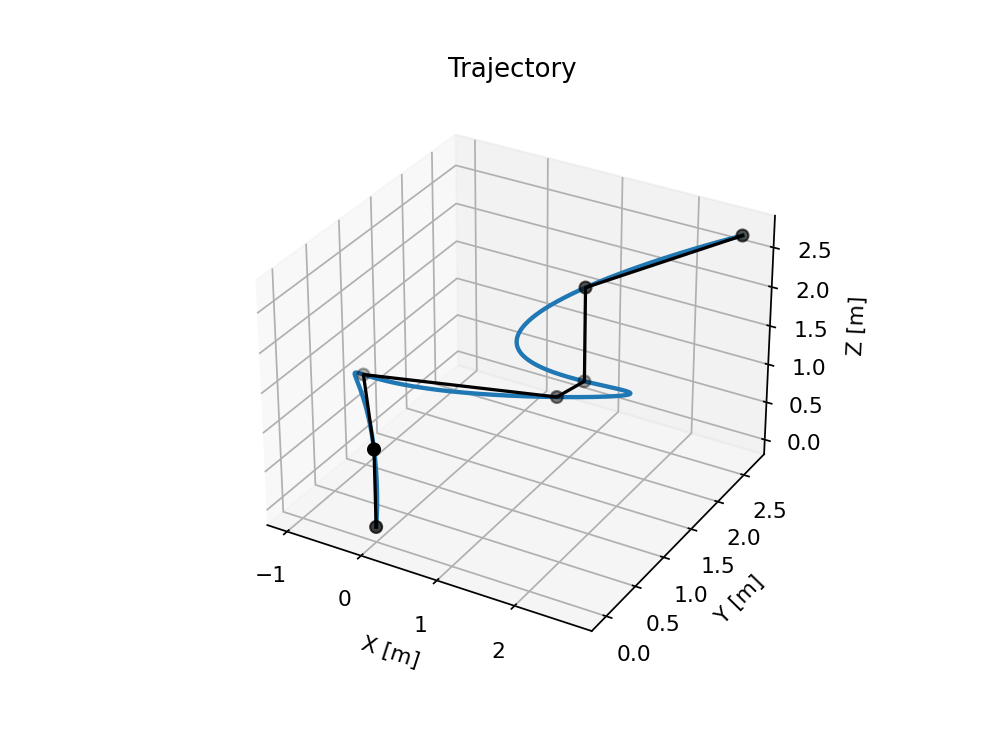

<IPython.core.display.Javascript object>


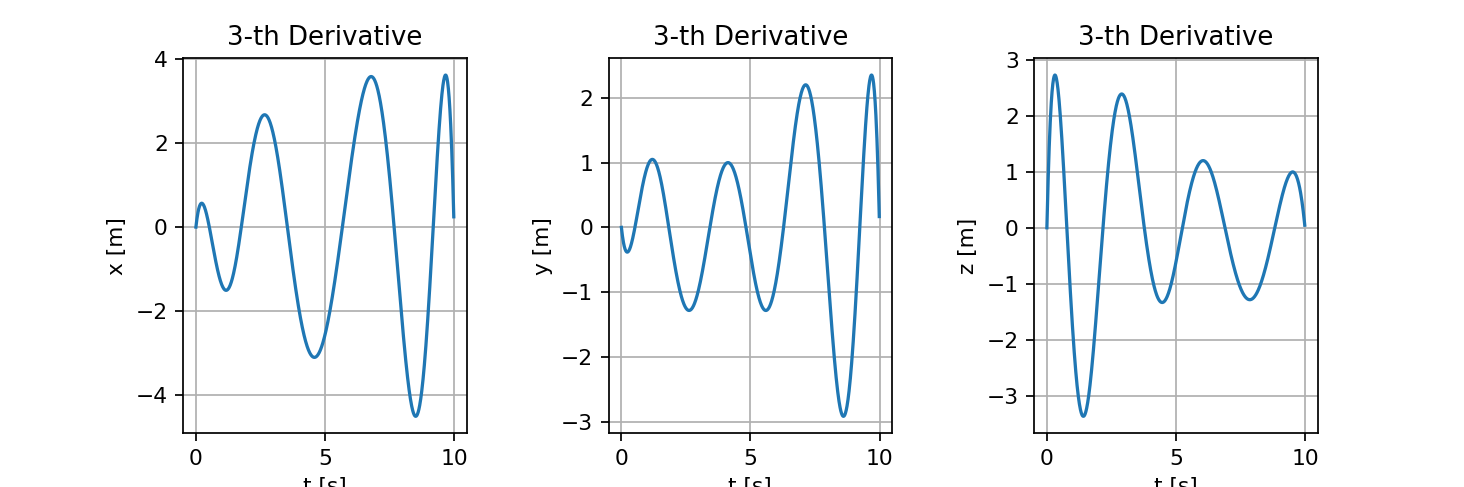

(<Figure size 600x200 with 3 Axes>,
 array([<AxesSubplot:title={'center':'3-th Derivative'}, xlabel='t [s]', ylabel='x [m]'>,
        <AxesSubplot:title={'center':'3-th Derivative'}, xlabel='t [s]', ylabel='y [m]'>,
        <AxesSubplot:title={'center':'3-th Derivative'}, xlabel='t [s]', ylabel='z [m]'>],
       dtype=object))

In [4]:
waypoints = np.array([[0, 0, 0],
                      [1, 0, 0],
                      [2, 2, 0],
                      [0, 3, 7]])

waypoints = np.array([[0, 0, 0],
                      [0, 0, 1],
                      [-1, 1, 1],
                      [1.2, 1.5, 1],
                      [1.3, 1.85, 1],
                      [1.3, 1.85, 2.2],
                      [2.7, 2.7, 2.7]])

T = 10
trajectory = MinimumSnapQP().generate(waypoints, T)

trajectory.plot()

# trajectory.plot_derivative(r=1)
# trajectory.plot_derivative(r=2)
trajectory.plot_derivative(r=3)


## Can We Do Better?

One of the issues with polynomials is the somewhat unpredictable deviation from the "safe" straight-line path. There are two quick changes to the above that can decrease the deviation.

1. **Waypoint subsampling**: By adding more and more waypoints in between the user-specified waypoints, the trajectory will have to stay closer to the original straight-line path. The obvious downside is that this is rather heuristic and may induce fast oscillations, or *ringing*, near waypoints that are too close.
2. **Loose pins**: So far, we have defined the waypoints using equality constraints $\mathbf{A}\mathbf{c}=\mathbf{b}$. These waypoints are **fixed pins** because we require the optimized trajectory to pass through these waypoints. By relaxing this equality constraint into an inequality constraint, we express that we do not care that waypoints are attained exactly. This can lead to trajectories with less energy/deviation.

A combination of these two points can be used to introduce **corridor constraints**, where the generated trajectory must stay within some maximum deviation from a straight-line trajectory.

#### Bibliography
```
[1] Diehl, M., Bock, H. G., Diedam, H., & Wieber, P. B. (2006). Fast direct multiple shooting algorithms for optimal robot control. In Fast motions in biomechanics and robotics (pp. 65-93). Springer, Berlin, Heidelberg.

[2] Russ Tedrake. Underactuated Robotics: Algorithms for Walking, Running, Swimming, Flying, and Manipulation (Course Notes for MIT 6.832). Downloaded on 23 Jan 2021 from http://underactuated.mit.edu/

[3] D. Mellinger and V. Kumar, "Minimum snap trajectory generation and control for quadrotors," 2011 IEEE International Conference on Robotics and Automation, Shanghai, 2011, pp. 2520-2525, doi: 10.1109/ICRA.2011.5980409.

[4] Richter, C., Bry, A., & Roy, N. (2016). Polynomial trajectory planning for aggressive quadrotor flight in dense indoor environments. In Robotics research (pp. 649-666). Springer, Cham.

[5] M. Burri, H. Oleynikova, M. W. Achtelik and R. Siegwart, "Real-time visual-inertial mapping, re-localization and planning onboard MAVs in unknown environments," 2015 IEEE/RSJ International Conference on Intelligent Robots and Systems (IROS), Hamburg, 2015, pp. 1872-1878, doi: 10.1109/IROS.2015.7353622.
```

# Incorporate half-space constraints

<IPython.core.display.Javascript object>


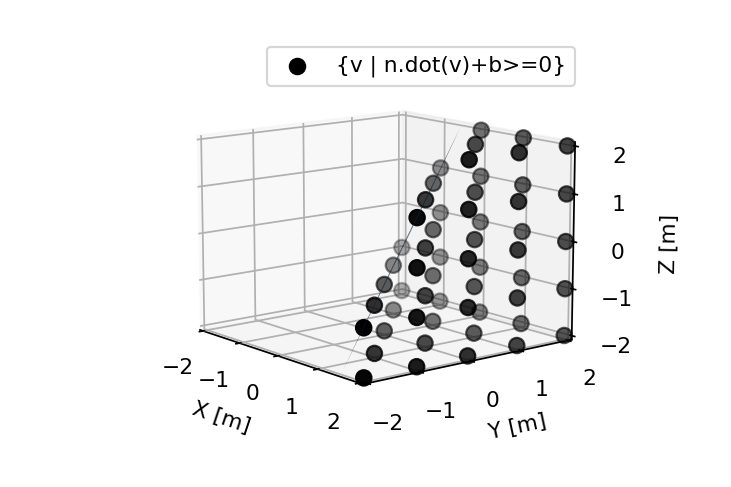

In [5]:

def surface_from_3pts(pts):
    """
    Solve for n.dot(x)+b=0, where n is the surface unit normal and b the offset.
    """
    assert pts.shape == (3,3)
    assert not np.array_equal(pts[0], pts[1]) \
           and not np.array_equal(pts[0], pts[2]) \
           and not np.array_equal(pts[1], pts[2])
    p0, p1, p2 = pts
    v0 = p0-p1
    v1 = p2-p1
    cross_v0v1 = np.cross(v0, v1)
    n = cross_v0v1 / np.linalg.norm(cross_v0v1)
    b = -np.inner(n, p0)
    return n, b
    
def surface_mesh(n, b, num_pts=5, lim=np.array([[-2, 2], [-2, 2], [-2, 2]])):
    i = np.nonzero(n)[0][0] # Find non-zero dimension of n
    j = np.array([k for k in range(3) if k != i]) # Other dims
    # Find meshgrid
    (j0mesh, j1mesh) = np.meshgrid(np.linspace(lim[j[0]][0], lim[j[0]][1], num_pts), 
                                   np.linspace(lim[j[1]][0], lim[j[1]][1], num_pts))
    imesh = -(j0mesh*n[j[0]] + j1mesh*n[j[1]] + b)/n[i]
    # Return xx, yy, zz
    results = [None]*3
    results[i] = imesh
    results[j[0]] = j0mesh
    results[j[1]] = j1mesh
    return results

def invalid_halfspace(n, b, num_pts=5, lim=np.array([[-2, 2], [-2, 2], [-2, 2]])):
    (xx, yy, zz) = np.meshgrid(np.linspace(lim[0][0], lim[0][1], num_pts), 
                               np.linspace(lim[1][0], lim[1][1], num_pts), 
                               np.linspace(lim[2][0], lim[2][1], num_pts))
    mask = xx*n[0]+yy*n[1]+zz*n[2]+b >= 0
    return xx[mask], yy[mask], zz[mask]

points = np.array([[1, 0, 1],
           [0, 1, 1],
           [-0.5, 0.5, -1]])


fig = plt.figure(figsize=(3,2))
ax = fig.add_subplot(1, 1, 1, projection='3d')

n, b = surface_from_3pts(points)
xx, yy, zz = surface_mesh(n, b)
ax.plot_surface(xx, yy, zz, alpha=0.8)

xx, yy, zz = invalid_halfspace(n, b)
ax.scatter(xx, yy, zz, s=50, c='k', label='{v | n.dot(v)+b>=0}')
ax.legend()
ax.set(xlim=[-2, 2], ylim=[-2, 2], zlim=[-2, 2])
# ax.set_title('Trajectory')
ax.set_xlabel('X [m]')
ax.set_ylabel('Y [m]')
ax.set_zlabel('Z [m]')
fig.tight_layout()
plt.show()

/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:119: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("P"))
/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:132: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("A"))


<IPython.core.display.Javascript object>


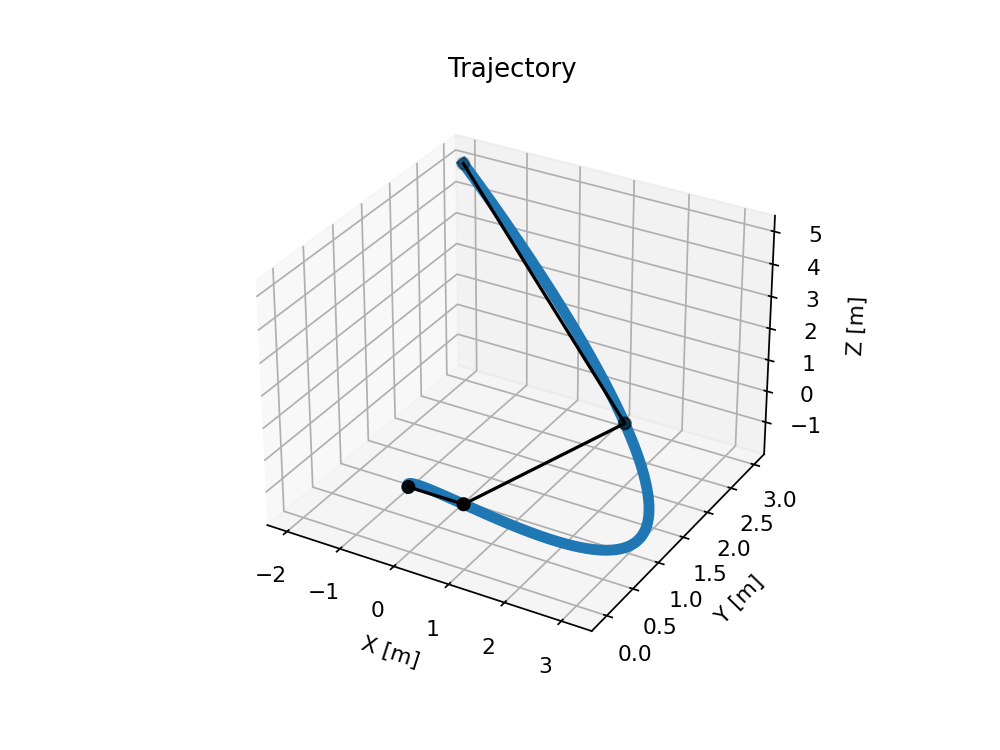

<IPython.core.display.Javascript object>


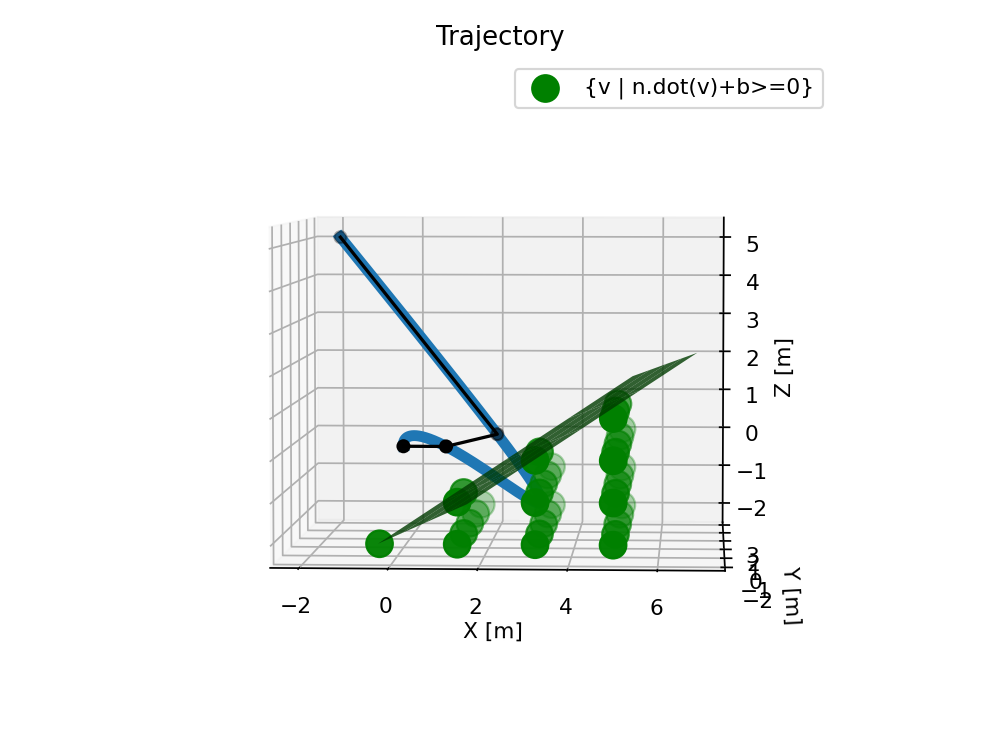

In [6]:
waypoints = np.array([[0, 0, 0],
                      [1, 0, 0],
                      [2, 2, 0],
                      [-2, 3, 5]])

T = 10
trajectory = MinimumSnapQP().generate(waypoints, T)
fig, ax = trajectory.plot(linewidth=5)
fig, ax = trajectory.plot(linewidth=5)


# Visualize the constraint halfspace
points = np.array([[2, 1, -1],
                   [3, 0.5, -0.2],
                   [3, 2, -0.5],
                   ])

n, b = surface_from_3pts(points)
xx, yy, zz = surface_mesh(n, b, lim=np.array([[-2, 2], [-2, 3], [-2, 2]]))
ax.plot_surface(xx, yy, zz, color='g', alpha=0.8)

xx, yy, zz = invalid_halfspace(n, b, lim=np.array([[-2, 5], [-2, 3], [-2, 2]]))
ax.scatter(xx, yy, zz, s=150, c='g', label='{v | n.dot(v)+b>=0}')
ax.legend()
fig.tight_layout()
plt.show()


# TODO: visualize halfspace, impose constraints on the sampled points
# TODO: _constraint_halfspace(self, segid, nsamples, normal, offset)
# TODO: _softwaypt(self,........)

# For halfspace constraint, the dimensions are coupled together

In [7]:
import numpy as np
from qpsolvers import solve_qp

class Trajectory:
    def __init__(self, N, M, r, d, ts, wps):
        self.N = N # polynomial order
        self.r = r # derivative to minimize
        self.d = d # spatial dimension of trajectory
        self.ncoeffs = self.N + 1 # number of poly coefficients
        self.M = M # number of segments (num waypoints - 1)
        self.ts = ts # segment durations
        self.wpt = np.cumsum(self.ts) # time at each wp
        self.wps = wps # original waypoint path specification
        
        self.polys = np.zeros((self.d, self.M*self.ncoeffs))
        
    def _get_seg_idx_range(self, i):
        """Get Segment Index Range
        Computes the appropriate index slice corresponding to the N+1
        coefficients of the ith polynomial segment.
        """
        return np.s_[ i*self.ncoeffs : (i+1)*self.ncoeffs ]
    
    def _polyval(self, c, t, r):
        """Evaulate the rth derivative of a polynomial with coeffs c at time t
        """
        def prod(r, n):
            x = 1
            for m in range(r):
                x *= (n - m)
            return x
        
        x = 0
        for n in range(len(c)):
            if n >= r:
                x += prod(r, n) * c[n] * t**(n-r)
        return x
        
    def set_poly(self, coeffs, dim=0):
        self.polys[dim,:] = coeffs
        
    def eval(self, t):
        """Evaluate the trajectory at a given time
        :ret: rxd np.array
        """
        x = np.zeros((self.r,self.d))
        
        for i in range(self.M):
            t0 = self.wpt[i-1] if i>0 else 0
            t1 = self.wpt[i]
            if t0 <= t < t1:
                tau = t - t0
                for d in range(self.d):
                    ci = self.polys[d, self._get_seg_idx_range(i)]
                    for r in range(self.r):
                        x[r,d] = self._polyval(ci, tau, r)
        return x
    
    def plot(self, Ts=0.01, linewidth=2):
        N = round(float(self.wpt[-1] / Ts)) # num samples
        X = np.zeros((self.r,self.d, N))
        
        for i in range(N):
            X[:,:,i] = self.eval(i*Ts)
            
        tvec = [i*Ts for i in range(N)]
        
#         fig = plt.figure(figsize=(10,4), dpi=100)
        fig = plt.figure(dpi=100)
        fig.subplots_adjust(hspace=0.3)
        if self.d == 3:
            ax = fig.add_subplot(111, projection='3d')
            ax.plot3D(X[0,0,:],X[0,1,:],X[0,2,:], linewidth=linewidth)
            
            # straight line path + waypoints
            ax.plot3D(self.wps[:,0],self.wps[:,1],self.wps[:,2],c='k')
            ax.scatter3D(self.wps[:,0],self.wps[:,1],self.wps[:,2],s=30,c='k')
            
            ax.grid()
            ax.set_title('Trajectory')
            ax.set_xlabel('X [m]')
            ax.set_ylabel('Y [m]')
            ax.set_zlabel('Z [m]')
        else:
            print("Only 3D trajectory plotting implemented")
        
        return fig, ax
            
    def plot_derivative(self, r, Ts=0.01):
        assert r > 0
        assert self.d == 3
        dim_names = ['x [m]', 'y [m]', 'z [m]']
        N = round(float(self.wpt[-1] / Ts)) # num samples
        X = np.zeros((self.r, self.d, N))
        
        for i in range(N):
            X[:,:,i] = self.eval(i*Ts)
            
        tvec = [i*Ts for i in range(N)]
        
        fig, axes = plt.subplots(1, self.d, figsize=(self.d*2, 2), dpi=100)
        fig.subplots_adjust(wspace=0.5)
        for i, dim in enumerate(dim_names):
            ax = axes[i]
            ax.plot(tvec, X[r,i,:])
            ax.grid()
            ax.set_title('{}-th Derivative'.format(r))
            ax.set_xlabel('t [s]')
            ax.set_ylabel(dim)
        return fig, axes


class MinimumSnapQP:
    """
    Formulates the minimum-snap polynomial trajectory
    optimization problem as a QP of the form
    
    Cannot seaprate into 3 separate QP, since xyz are coupled in the hyperplane constraint
    
        min  c'Qc
        s.t  Ac = b
             Gc < h
    """
    def __init__(self, N=7, r=4, d=3):
        self.N = N # polynomial order
        self.r = r # derivative to minimize
        self.d = d # spatial dimension of trajectory
        self.ncoeffs = self.N + 1 # number of poly coefficients
        self.M = 0 # number of segments (num waypoints - 1)
        self.L = 0 # length of decision variable c, i.e., M(N+1)
    
    def _initial_time_allocation(self, wps, T):
        ts = []
        t = T / self.M
        for i in range(self.M):
            ts.append(t)
        
        return ts
    
    def _build_Qi(self, tsi=1):
        """Build quadratic cost matrix of i-th segment
        Note that each Qi is only a function of segment duration.
        """
        Qi = np.zeros((self.ncoeffs, self.ncoeffs))
        
        def prod(r, o, p):
            x = 1
            for m in range(r):
                x *= (o-m) * (p-m)
            return x
        
        for o in range(self.ncoeffs):
            for p in range(self.ncoeffs):
                if o >= self.r and p >= self.r: # equivalently, e > 0
                    e = o + p - 2*self.r + 1
                    Qi[o,p] = 2 * prod(self.r, o, p) * tsi**e / e
        return Qi
    
    def _build_Q(self, ts):
        """Build total quadratic
        This is Q = blkdiag(Q1, ..., Q_M).
        """
        Q = np.zeros((self.M*self.ncoeffs, self.M*self.ncoeffs))
        
        for i in range(self.M):
            idx = self._get_seg_idx_range(i)
            Q[idx, idx] = self._build_Qi(ts[i])
        return Q
    
    def _get_seg_idx_range(self, i, ioffset=0):
        """Get Segment Index Range
        Computes the appropriate index slice corresponding to the N+1
        coefficients of the ith polynomial segment.
        """
        return np.s_[ i*self.ncoeffs+ioffset : (i+1)*self.ncoeffs+ioffset ]
    
    def _get_tvec_at(self, t, r=0):
        """Creates time vector associated with polynomial.
        σ(t) = c_0  +  c_1 t  + ... +  c_N t^N = <c,tvec>,
        with tvec|r=0 = [1 t ... t^N], tvec|r=1 = [0 1 ... t^(N-1)], ...
        :return: tvec associated with rth derivative of σ(t), eval at time t.
        """
        def prod(r, n):
            x = 1
            for m in range(r):
                x *= (n - m)
            return x
        
        tvec = np.zeros((self.ncoeffs,))
        for n in range(self.ncoeffs):
            if n >= r:
                tvec[n] = prod(r, n) * t**(n-r)
        return tvec
    
    def _constraint_endpoints(self, wps, ts):
        """Endpoint Constraints
        Enforce that the starting and ending positions are met at rest.
        """
        k = 2 # number of waypoints being constrained (start and end points)
        A = np.zeros((k*self.r, self.L))
        b = np.zeros((k*self.r,))
        
        # constraints on starting position (at rest)
        idx = self._get_seg_idx_range(0)
        for r in range(self.r):
            A[r, idx] = self._get_tvec_at(0, r)
        b[0*self.r] = wps[0]
        
        # constraints on ending position (at rest)
        idx = self._get_seg_idx_range(self.M-1)
        for r in range(self.r):
            A[r+self.r, idx] = self._get_tvec_at(ts[-1], r)
        b[1*self.r] = wps[-1]
        
        return A, b
    
    def _constraint_waypoints(self, wps, ts):
        """Waypoint Constraints
        Enforce positions on middle waypoints (i.e., not start or end)
        """
        A = np.zeros((self.M-1, self.L))
        b = np.zeros((self.M-1,))
        
        for i in range(self.M-1):
            idx = self._get_seg_idx_range(i)
            A[i, idx] = self._get_tvec_at(ts[i], r=0)
            b[i] = wps[i+1]
        
        return A, b
    
    def _constraint_smoothness(self, wps, ts):
        """Smoothness Constraints
        Enforce continuity constraint between segments
        """
        k = self.M - 1 # the end of the last segment is the traj endpoint, skip
        A = np.zeros((k*self.r, self.L))
        b = np.zeros((k*self.r,))
        
        for i in range(self.M-1):
            idx1 = self._get_seg_idx_range(i)
            idx2 = self._get_seg_idx_range(i+1)
            for r in range(self.r):
                A[r+i*self.r, idx1] = self._get_tvec_at(ts[i], r)
                A[r+i*self.r, idx2] = -1*self._get_tvec_at(0, r)
        
        return A, b
    
    def _build_eq_const(self, wps, ts):
        """Build Equality Constraints
        """
        Aend, bend = self._constraint_endpoints(wps, ts)
        Awps, bwps = self._constraint_waypoints(wps, ts)
        Asmt, bsmt = self._constraint_smoothness(wps, ts)
        
        A = np.vstack((Aend, Awps, Asmt))
        b = np.concatenate((bend, bwps, bsmt))
        return A, b
    
    def _constraint_halfspaces(self, segment_ids, normals, offsets, ts, nsamples=5):
        """
        normals = np.array([[n1, n2], [n3]])
        normals = np.array([b1, b2], [b3])
        """
        # TODO: current version has duplicate constraints at endpoints
        num = 0
        assert len(segment_ids)==len(normals)==len(offsets)
        for i, normal_list, offset_list in zip(segment_ids, normals, offsets):
            assert len(normal_list) == len(offset_list)
            num += len(offset_list)*(nsamples+2)*self.d
        G = np.zeros((num, self.L*3)) # *3 cuz xyz dimensions are coupled
        h = np.zeros((num, ))
        
        # Subsample 
        for i, normal_list, offset_list in zip(segment_ids, normals, offsets):

            tsamples = np.linspace(0, ts[i], nsamples+2)
#             idx = self._get_seg_idx_range(i) # N+1 coeffs
            
            # index offsets
            seg_offset = (nsamples+2)*len(normal_list)
            hs_offset = (nsamples+2)
            for nid, (normal, offset) in enumerate(zip(normal_list, offset_list)):
                for tid, t in enumerate(tsamples):
                    toffset = i*seg_offset+nid*hs_offset+tid
                    xcoeff_idx = self._get_seg_idx_range(i, ioffset=0)
                    ycoeff_idx = self._get_seg_idx_range(i, ioffset=self.L)
                    zcoeff_idx = self._get_seg_idx_range(i, ioffset=2*self.L)
                    G[toffset, xcoeff_idx] = self._get_tvec_at(t, r=0)*normal[0] # x*n[0]
                    G[toffset, ycoeff_idx] = self._get_tvec_at(t, r=0)*normal[1] # y*n[1]
                    G[toffset, zcoeff_idx] = self._get_tvec_at(t, r=0)*normal[2] # z*n[2]
                    # [x,y,z].dot(n) < -b
                    h[toffset] = -offset
        return G, h
    
    def generate(self, wps, T, 
                 segment_ids=[], normals=[], offsets=[], nsamples=5,
                 soft_wps=[]):
        """
        Solve one big QP involving xyz
        """
        self.M = len(wps) - 1
        self.L = self.M * (self.N + 1)
        
        ts = self._initial_time_allocation(wps, T)
        
        Q = self._build_Q(ts)
        
        traj = Trajectory(self.N, self.M, self.r, self.d, ts, wps)
        
        # Combine all equality constraint
        Aeq_list = []
        beq_list = []
        for d in range(self.d):
            Aeq, beq = self._build_eq_const(wps[:,d], ts)
            Aeq_list.append(Aeq)
            beq_list.append(beq)
        Aeq = block_diag(*Aeq_list)
        beq = np.concatenate(beq_list)
        
        num_const_each_dim = Aeq.shape[0]/self.d
        
        # Formulate halfspace constraints
        if len(segment_ids)!=0 and len(normals)!=0 and len(offsets)!=0:
            G, h = self._constraint_halfspaces(segment_ids, normals, offsets, ts, nsamples=nsamples)
        else:
            G=None
            h=None
        
        Q = block_diag(Q, Q, Q) # xyz
        c = solve_qp(Q, np.zeros((Aeq.shape[1],)), A=Aeq, b=beq, G=G, h=h, solver='osqp')
        for d in range(self.d):
            traj.set_poly(c[d*self.ncoeffs*self.M:(d+1)*self.ncoeffs*self.M], dim=d)
        
        return traj

/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:119: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("P"))
/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:132: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("A"))


<IPython.core.display.Javascript object>


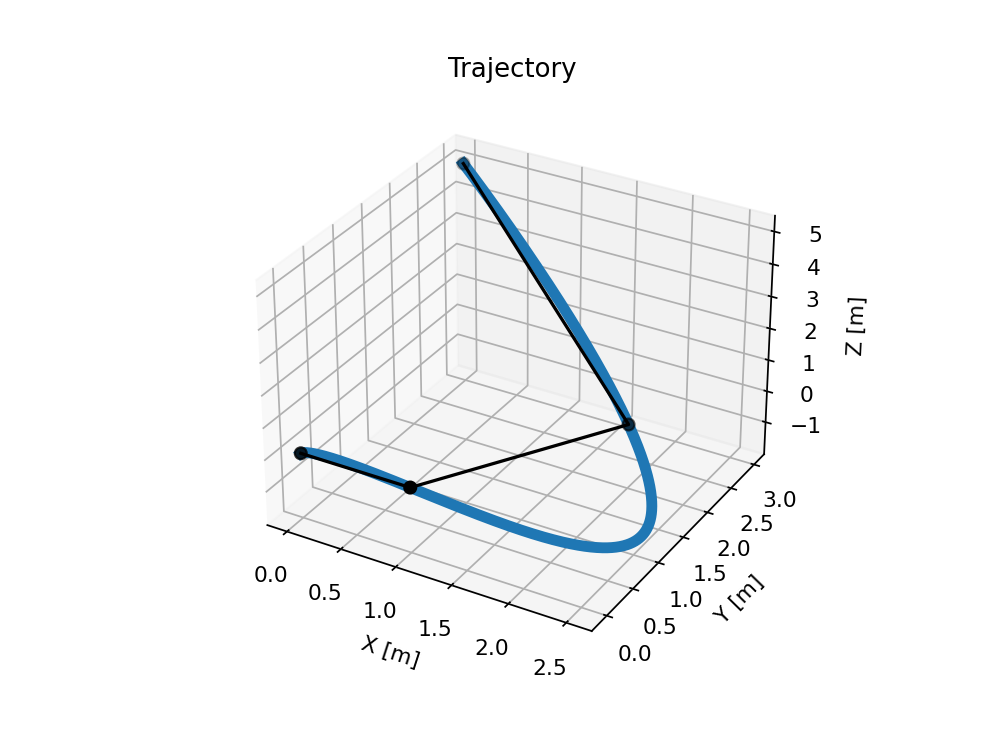

<IPython.core.display.Javascript object>


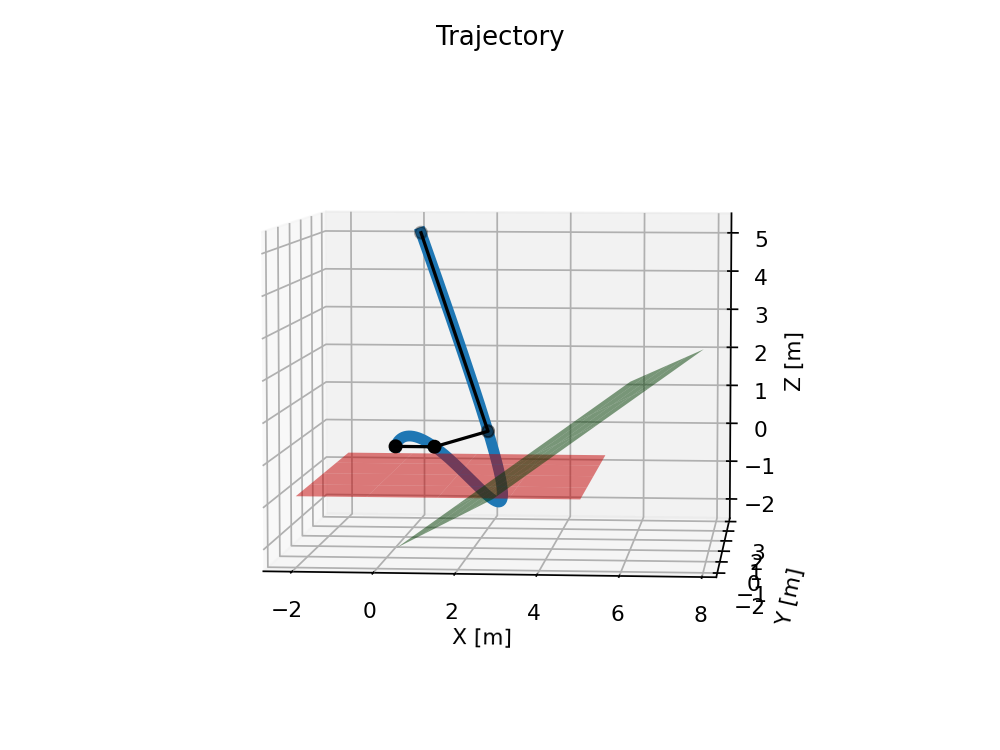

/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:119: UserWarning: Converted P to scipy.sparse.csc.csc_matrix
For best performance, build P as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("P"))
/home/jeremy/.local/lib/python3.6/site-packages/qpsolvers/osqp_.py:132: UserWarning: Converted A to scipy.sparse.csc.csc_matrix
For best performance, build A as a csc_matrix rather than as a numpy.ndarray
  warn(conversion_warning("A"))


<IPython.core.display.Javascript object>


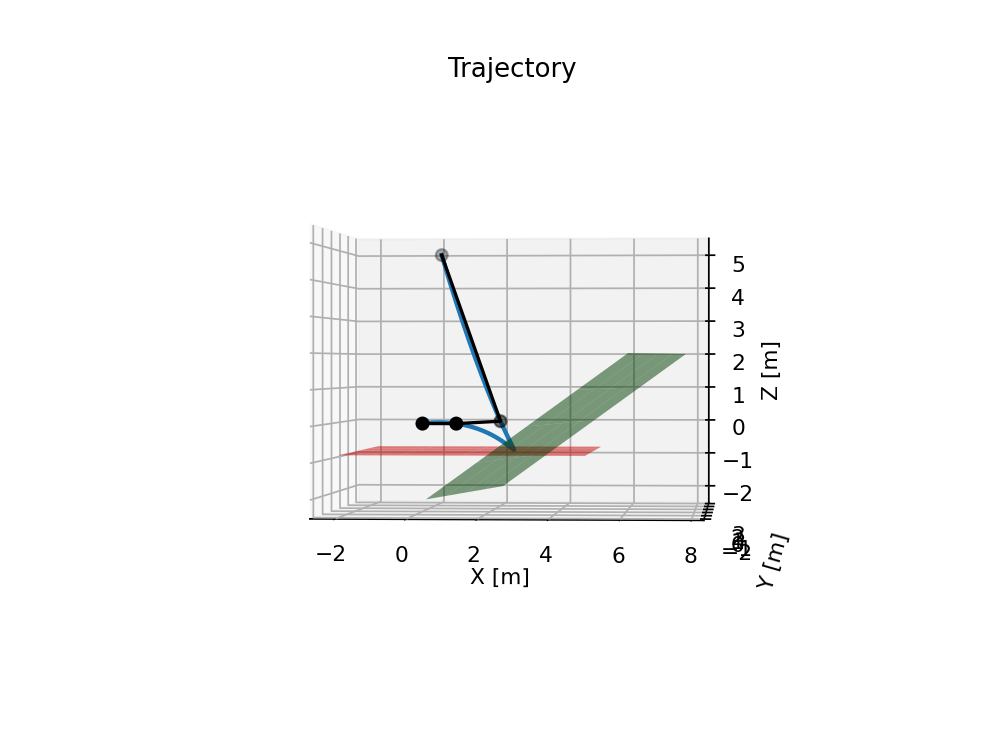

In [8]:
waypoints = np.array([[0, 0, 0],
                      [1, 0, 0],
                      [2, 2, 0],
                      [0, 3, 5]])

T = 10
trajectory = MinimumSnapQP().generate(waypoints, T)
fig, ax = trajectory.plot(linewidth=5)
fig, ax = trajectory.plot(linewidth=5)


# Visualize the constraint halfspace
points = np.array([[2.5, 0.0, -1],
                   [3.5, -0.5, -0.2],
                   [3.5, 1.0, -0.5],
                   ])
points2 = np.array([[3.5, -0.5, -0.8],
                    [2.5, -0.2, -.8],
                   [0.5, -0.5, -0.8],
                   ])

n, b = surface_from_3pts(points)

n2, b2 = surface_from_3pts(points2)

xxm, yym, zzm = surface_mesh(n, b, lim=np.array([[-2, 2], [-2, 3], [-2, 2]]))
xx2m, yy2m, zz2m = surface_mesh(n2, b2, lim=np.array([[-2, 5], [-2, 3], [-2, 2]]))
ax.plot_surface(xxm, yym, zzm, color='g', alpha=0.5)
ax.plot_surface(xx2m, yy2m, zz2m, color='r', alpha=0.5)

# xxhs, yyhs, zzhs = invalid_halfspace(n, b, lim=np.array([[-2, 5], [-2, 3], [-2, 2]]))
# xx2hs, yy2hs, zz2hs = invalid_halfspace(n2, b2, lim=np.array([[-2, 5], [-2, 3], [-2, 2]]))
# ax.scatter(xxhs, yyhs, zzhs, s=50, c='g', alpha=0.5, label='{v | n1.dot(v)+b1>=0}')
# ax.scatter(xx2hs, yy2hs, zz2hs, s=50, c='r', alpha=0.5, label='{v | n2.dot(v)+b2>=0}')
# ax.legend()
fig.tight_layout()
plt.show()


# Accounting for hyperplane
segment_ids=[1]
normals=[[n, n2]]
offsets=[[b, b2]]
trajectory = MinimumSnapQP().generate(waypoints, T, segment_ids, normals, offsets, nsamples=5)
fig, ax = trajectory.plot(linewidth=2)
ax.plot_surface(xxm, yym, zzm, color='g', alpha=0.5)
ax.plot_surface(xx2m, yy2m, zz2m, color='r', alpha=0.5)
plt.show()

# Soft waypoint constraint

# How to account for yaw? Can we always enforce yaw?